# Mr Jornet's First Ascend to Everest

The question was how close the GPX track from the Strava activity https://www.strava.com/activities/1022238076 got to the summit of Mt. Everest.
This repository holds the gpx track, downloaded with the bookmarklet from https://mapstogpx.com/strava/ and this notebook does some processing on it.

## TL;DR

With [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System) and distance calculation by [pyproj.Geod.inv](https://jswhit.github.io/pyproj/pyproj.Geod-class.html#inv) the calculated distance is 54 meters.

In [1]:
%matplotlib inline

import gpxpy #.parser as parser
from pandas import DataFrame
import geopandas as gpd
import shapely.wkt
from shapely.geometry import Point

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

In [2]:
gpx_file = open('../../../data//strava_full_activities-1022238076.gpx', 'r')

gpx = gpxpy.parse(gpx_file)

In [3]:
# create a Pandas DataFrame as a starter
data = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            data.append([point.longitude, point.latitude, point.elevation, point.time, point.name])
columns = ['Longitude', 'Latitude', 'Altitude', 'Time', 'Name']

df = DataFrame(data, columns=columns)

df.head()

,Longitude,Latitude,Altitude,Time,Name
0,86.854822,28.135588,5238.0,2017-12-05 06:36:16,TP00001
1,86.854848,28.135583,5238.0,2017-12-05 06:36:18,TP00002
2,86.854874,28.135580,5238.0,2017-12-05 06:36:20,TP00003
3,86.854892,28.135571,5238.0,2017-12-05 06:36:22,TP00004
4,86.854934,28.135575,5238.0,2017-12-05 06:36:24,TP00005


In [4]:
# Now create a GeoPandas DataFrame from it
#https://gis.stackexchange.com/a/174168/87254 et al
gdf = gpd.GeoDataFrame(df.drop(['Longitude', 'Latitude'], axis=1),
                       crs={'init': 'epsg:4326'},
                       geometry=df.apply(lambda row: shapely.geometry.Point((row.Longitude, row.Latitude)), axis=1))
gdf.head()

,Altitude,Time,Name,geometry
0,5238.0,2017-12-05 06:36:16,TP00001,POINT (86.854822 28.135588)
1,5238.0,2017-12-05 06:36:18,TP00002,POINT (86.854848 28.135583)
2,5238.0,2017-12-05 06:36:20,TP00003,POINT (86.854874 28.13558)
3,5238.0,2017-12-05 06:36:22,TP00004,POINT (86.85489200000001 28.135571)
4,5238.0,2017-12-05 06:36:24,TP00005,POINT (86.854934 28.135575)


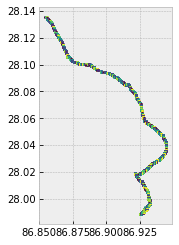

In [5]:
gdf.plot()

In [6]:
from shapely.ops import nearest_points
gdfmp = gdf.unary_union
everest = Point(86.925278, 27.988056)

nearestpoints = nearest_points(everest, gdfmp)

In [7]:
import pyproj
geod = pyproj.Geod(ellps='WGS84')
angle1,angle2,distance = geod.inv(nearestpoints[0].x, nearestpoints[0].y, nearestpoints[1].x, nearestpoints[1].y)
print("The nearest points are located {0:8.4f} meters from each other.".format(distance))

The nearest points are located  54.4735 meters from each other.


## appendix

Not sure if a more local CRS would bring a much different result, but my morning train commutes comes to an end.
https://gis.stackexchange.com/questions/126546/transformation-parameters-for-everest-datum-to-wgs84 might hold the next step.
